## Protein Classfication

## Imports

In [1]:
import textwrap
import random

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Module

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool, global_add_pool

from mpl_toolkits.mplot3d import Axes3D

## Setup

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
SEED = 8225

In [4]:
def seed() -> None:
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch_geometric.seed_everything(SEED)

In [5]:
seed()

## Load the PROTEIN dataset

In [6]:
dataset = TUDataset(root='.', name='PROTEINS')

In [7]:
print(f'Number of graphs: {len(dataset)}')
print(f'Shape: {dataset[0].x.shape}') # (number of nodes, number of node features)
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1113
Shape: torch.Size([42, 3])
Number of classes: 2


In [8]:
dataset[69]

Data(edge_index=[2, 90], x=[26, 3], y=[1])

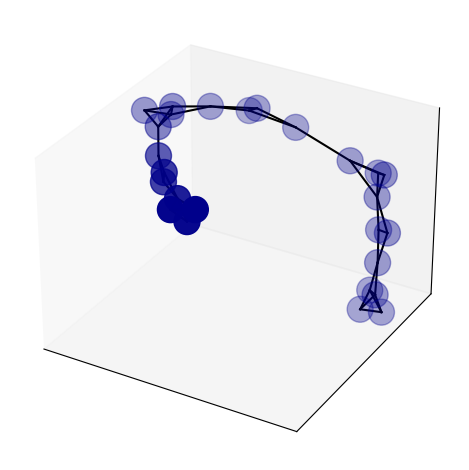

In [9]:
graph = to_networkx(dataset[69], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(graph, dim=3, seed=SEED)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(graph)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in graph.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for dim in (ax.xaxis, ax.yaxis, ax.zaxis): dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=350, c="darkblue")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="black")

fig.tight_layout()
plt.show()

## Prepare data

In [10]:
BATCH_SIZE = 64

In [11]:
def create_data_loader(dataset, batch_size = BATCH_SIZE):
    seed()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
seed()
dataset = dataset.shuffle()
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset: 891, val_dataset: 111, test_dataset: 111


In [13]:
train_loader = create_data_loader(train_dataset)
val_loader = create_data_loader(val_dataset)
test_loader = create_data_loader(test_dataset)

for name, train_dataloader in zip(('Train', 'Validation', 'Test'), (train_loader, val_loader, test_loader)):
    print(f'{name} loader:')
    for i, subgraph in enumerate(train_dataloader):
        print(f' - Subgraph {i}: {subgraph}')

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 9770], x=[2626, 3], y=[64], batch=[2626], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 9294], x=[2516, 3], y=[64], batch=[2516], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9032], x=[2324, 3], y=[64], batch=[2324], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 11208], x=[3014, 3], y=[64], batch=[3014], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 9516], x=[2561, 3], y=[64], batch=[2561], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 9882], x=[2699, 3], y=[64], batch=[2699], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 10530], x=[2866, 3], y=[64], batch=[2866], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 9202], x=[2480, 3], y=[64], batch=[2480], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 7290], x=[1911, 3], y=[64], batch=[1911], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 9250], x=[2471, 3], y=[64], batch=[2471], ptr=[65])
 - Subgraph 10: DataBatch(edge_index=[2, 8842], x=[2314, 3], y=[

## Model Architecture

In [14]:
class GraphConvolutionalNetwork(Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, dropout_rate=0.5):
        super(GraphConvolutionalNetwork, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)

        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)

        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.bn5 = BatchNorm1d(hidden_channels)

        self.lin = Linear(hidden_channels, num_classes)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = x.relu()

        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = x.relu()

        x = self.conv5(x, edge_index)
        x = self.bn5(x)
        x = x.relu()

        x_graph = global_mean_pool(x, batch)
        x = self.lin(x_graph)
        return x_graph, torch.nn.functional.sigmoid(x)

In [15]:
class GraphIsomorphismNetwork(Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, dropout_rate=0.5):
        super(GraphIsomorphismNetwork, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(num_node_features, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv2 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv3 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv4 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))

        self.conv5 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.lin1 = Linear(hidden_channels*5, hidden_channels*5)
        self.lin2 = Linear(hidden_channels*5, num_classes)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch) -> tuple[torch.Tensor, torch.Tensor]:
        h1 = self.conv1(x, edge_index)
        h1 = self.dropout(h1)

        h2 = self.conv2(h1, edge_index)
        h2 = self.dropout(h2)

        h3 = self.conv3(h2, edge_index)
        
        h4 = self.conv4(h3, edge_index)

        h5 = self.conv5(h4, edge_index)


        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h4 = global_add_pool(h4, batch)
        h5 = global_add_pool(h5, batch)

        h = torch.cat([h1, h2, h3, h4, h5], dim=1)

        h = self.lin1(h).relu()
        h = self.dropout(h)
        h = self.lin2(h)

        return h, torch.nn.functional.sigmoid(h)



## Training

In [16]:
def accuracy(pred_y, y): 
    return ((pred_y.argmax(dim=1) == y).sum() / len(y)).item()

In [17]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-2
N_EPOCHS = 100
N_HIDDEN = 256

In [18]:
def evaluate(model: Module, loader: DataLoader, device: torch.device) -> tuple[float, float]:
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    model = model.to(device)
    for data in loader:
      data = data.to(device)
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out, data.y) / len(loader)

    return loss, acc

In [19]:
def train(model: Module, train_dataloader: DataLoader, val_dataloader: DataLoader, device: torch.device) -> Module:
    seed()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    model = model.to(device)
    best_val_acc = 0
    best_epoch = 0
    for epoch in range(1, N_EPOCHS+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        model.train()
        for data in train_dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(train_dataloader)
            acc += accuracy(out, data.y) / len(train_dataloader)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(
            model, 
            val_dataloader,
            device=device
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

        print(
            textwrap.dedent(f"""
                Epoch {epoch} / {N_EPOCHS}
                Train Loss: {total_loss}
                Val Loss: {val_loss}
                Train Acc: {acc}%
                Val Acc: {val_acc}%
            """)
        )
    print(f"Best validation accuracy: {best_val_acc} at epoch {best_epoch}")
    return model

In [20]:
model = GraphIsomorphismNetwork(
    hidden_channels=N_HIDDEN,
    num_node_features=dataset.num_node_features,
    num_classes=dataset.num_classes
)

In [21]:
train(
    model,
    train_loader,
    val_loader,
    device
)


Epoch 1 / 100
Train Loss: 0.6207787394523621
Val Loss: 0.603158175945282
Train Acc: 0.6431030588490622%
Val Acc: 0.6557513177394867%


Epoch 2 / 100
Train Loss: 0.6112674474716187
Val Loss: 0.6510701179504395
Train Acc: 0.6637598361287799%
Val Acc: 0.6529255211353302%


Epoch 3 / 100
Train Loss: 0.6033194065093994
Val Loss: 0.6099950075149536
Train Acc: 0.6665405588490623%
Val Acc: 0.6884973347187042%


Epoch 4 / 100
Train Loss: 0.6006581783294678
Val Loss: 0.6195003986358643
Train Acc: 0.6763960335935864%
Val Acc: 0.6444481313228607%


Epoch 5 / 100
Train Loss: 0.5912852883338928
Val Loss: 0.6202051639556885
Train Acc: 0.6937991849013737%
Val Acc: 0.6707114279270172%


Epoch 6 / 100
Train Loss: 0.6022244691848755
Val Loss: 0.6120862364768982
Train Acc: 0.6858921008450645%
Val Acc: 0.6672207415103912%


Epoch 7 / 100
Train Loss: 0.590237557888031
Val Loss: 0.6044756174087524
Train Acc: 0.6993795420442308%
Val Acc: 0.7026263177394867%


Epoch 8 / 100
Train Loss: 0.600247323513031
Val L

GraphIsomorphismNetwork(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
  ))
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, 